In [1]:
import pickle, os, gzip, json
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import pynndescent
from sklearn.feature_extraction.text import TfidfTransformer
import umap
import scipy as sp

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300

import sys
sys.path.append("../../scripts")

## Load data

In [2]:
import data_io
reload(data_io)
from data_io import is_fwd_id, get_fwd_id

import nearest_neighbors
reload(nearest_neighbors)
from nearest_neighbors import (
    get_overlap_candidates,
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
)

import truth
reload(truth)
from truth import get_overlaps


import graph
reload(graph)
from graph import ReadGraph, GenomicInterval

/home/ecs-user/workspace/kNN-overlap-finder/scripts/../lib


In [19]:
sample = "CHM13"
region = "TRA"
dataset = "pbsim_ONT_95_30k"
sample_size = 2_000

prefix = f"../../data/feature_matrix/kmer/{sample}/{region}/{dataset}/"

npz_path = os.path.join(prefix, "feature_matrix.npz")
tsv_path = os.path.join(prefix, "metadata.tsv.gz")
json_path = os.path.join(prefix, "read_features.json.gz")

feature_matrix = sp.sparse.load_npz(npz_path)[:sample_size, :]
meta_df = pd.read_table(tsv_path).iloc[:sample_size, :].set_index("read_id")

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)[:sample_size]
    read_features = {i: features for i, features in enumerate(read_features)}
    
read_intervals = {
    i: [GenomicInterval("", start, end)]
    for i, start, end in zip(
        meta_df.index, meta_df["reference_start"], meta_df["reference_end"]
    )
}
feature_weights = {i: 1 for i in range(feature_matrix.shape[1])}

Text(0, 0.5, 'Number of reads')

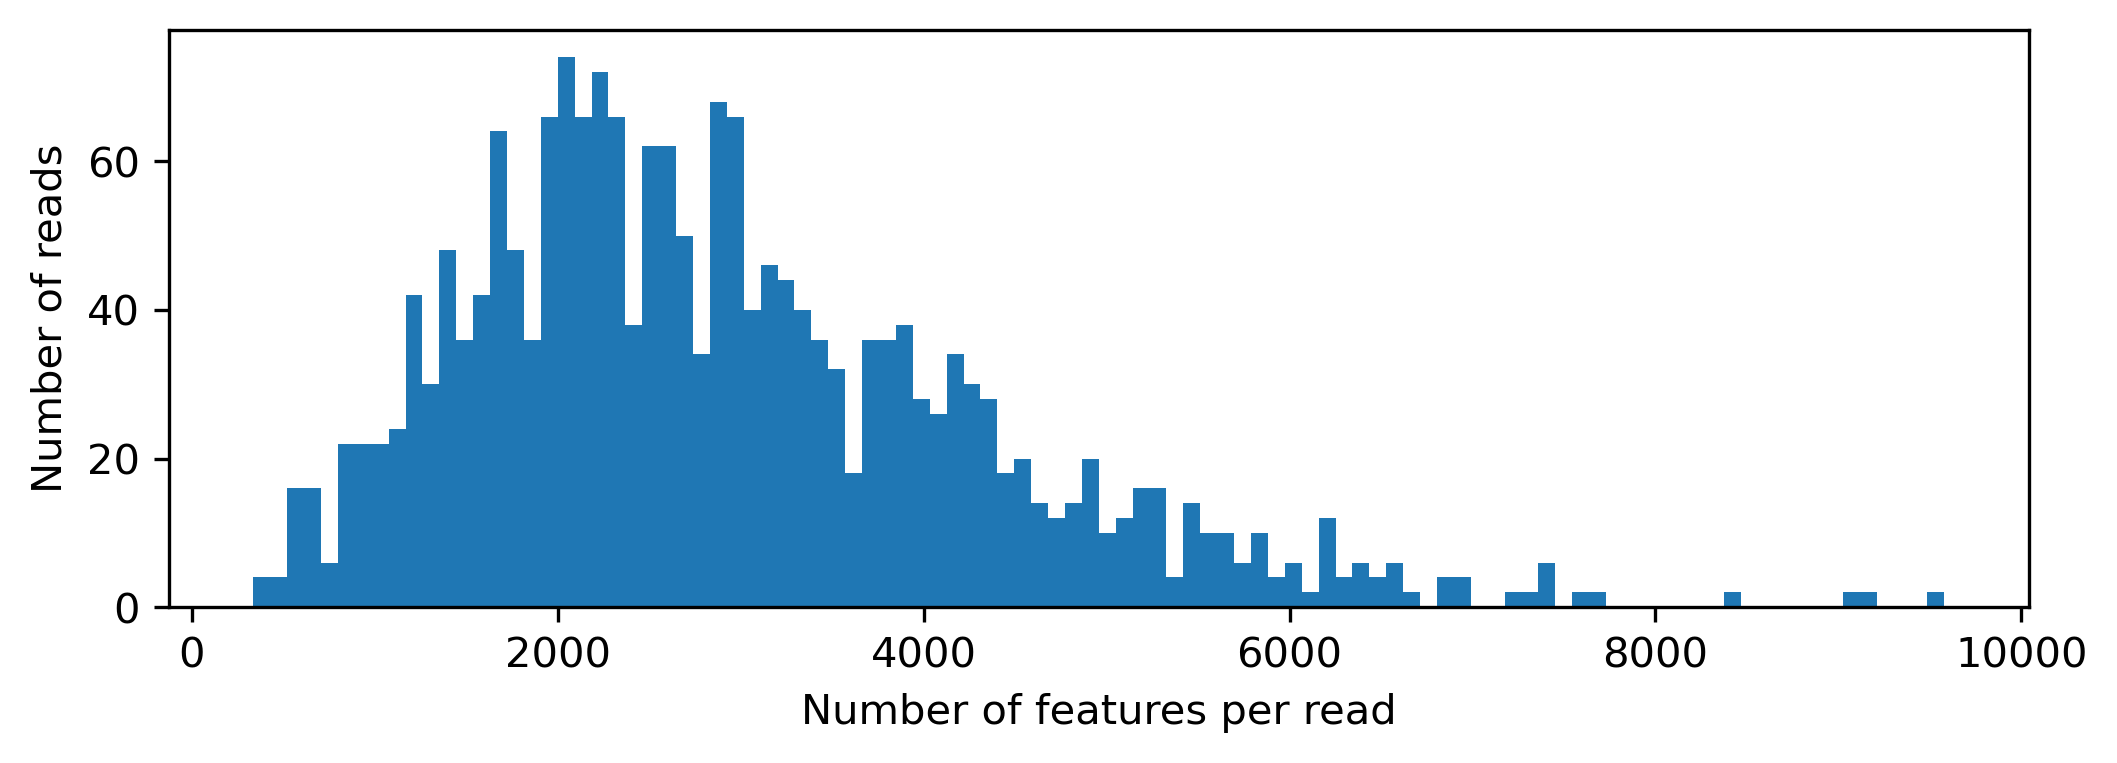

In [21]:
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.hist([len(x) for x in read_features.values()], bins=100);
ax.set_xlabel("Number of features per read")
ax.set_ylabel("Number of reads")

In [22]:
feature_matrix.shape

(2000, 102644)

In [23]:
meta_df

read_name read_orientation  read_length reference_strand  \
read_id                                                            
0            S1_1                +        54495                +   
1            S1_1                -        54495                +   
2            S1_2                +        30645                -   
3            S1_2                -        30645                -   
4            S1_3                +        29367                +   
...           ...              ...          ...              ...   
1995       S1_998                -        21487                -   
1996       S1_999                +        42854                +   
1997       S1_999                -        42854                +   
1998      S1_1000                +        34792                -   
1999      S1_1000                -        34792                -   

         reference_start  reference_end  
read_id                                  
0                1982239        2036877  
1                1982239        2036877  
2                1458288        1488950  
3                1458288        1488950  
4                1771638        1801186  
...                  ...            ...  
1995              165055         186689  
1996             1878024        1920911  
1997             1878024        1920911  
1998             2058109        2093276  
1999             2058109        2093276  

[2000 rows x 6 columns]

In [24]:
reference_graph = ReadGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges)

(2000, 42604, 2857)

## Get nearest neighbours

In [88]:
import nearest_neighbors
reload(nearest_neighbors)
from nearest_neighbors import (
    get_overlap_candidates,
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
    _NearestNeighbors
)

In [92]:
import evaluate
reload(evaluate)
from evaluate import NearestNeighborsConfig, mp_evaluate_configs

In [95]:
config_list = [
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=False,
        dim_reduction=100,
        n_neighbors=24,
        kw=dict(metric="cosine"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=None,
        n_neighbors=24,
        kw=dict(metric="cosine"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=100,
        n_neighbors=24,
        kw=dict(metric="cosine"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=False,
        dim_reduction=100,
        n_neighbors=24,
        kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=None,
        n_neighbors=24,
        kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=100,
        n_neighbors=24,
        kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=False,
        n_neighbors=12,
        kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=True,
        n_neighbors=12,
        kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
]

In [96]:
pickle_file = "data/pickle/alignment_dict.pickle.gz"
mp_evaluate_configs(
    config_list,
    alignment_pickle_path=pickle_file,
    feature_matrix=feature_matrix,
    feature_weights=feature_weights,
    read_features=read_features,
    post_align_n_neighbors=6,
    processes=8,
    reference_graph=reference_graph,
)

NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, use_tfidf=False, dim_reduction=100, n_neighbors=24, kw={'metric': 'cosine'}, time=None, pre_align_stats=None, post_align_stats=None)

 Post-alignment: precision=0.483 nr_precision=0.029 recall=0.204 nr_recall=0.181 

1000	11.86		200	22.71		600	32.98		800	43.62		1200	53.71		400	64.14		1400	74.41		0	83.74		1600	55.12		1800	59.04		2200	63.32		2600	68.58		3000	73.44		2000	77.97		2800	81.19		2400	85.02		3400	69.30		3200	72.84		3800	73.75		3600	76.84		4000	77.65		4200	81.20		4600	82.96		4400	86.53		4800	76.86		5000	78.70		5200	78.57		5400	80.87		6000	81.05		5800	83.81		5600	86.10		6200	88.27		6400	80.52		6600	82.64		6800	83.02		7000	83.19		7600	84.89		7200	86.80		7400	88.57		7800	89.32		8200	83.32		8400	84.08		8000	85.86		8600	85.96		8800	87.57		9200	88.71		9000	90.04		9400	88.62		9800	90.03		9600	89.47		
 Pre-alignment: precision=0.582 nr_precision=0.048 recall=0.094 nr_recall=0.117 

NearestNeighborsConfig(met

## Visualisation

In [97]:
# Plots
import plots

reload(plots)
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

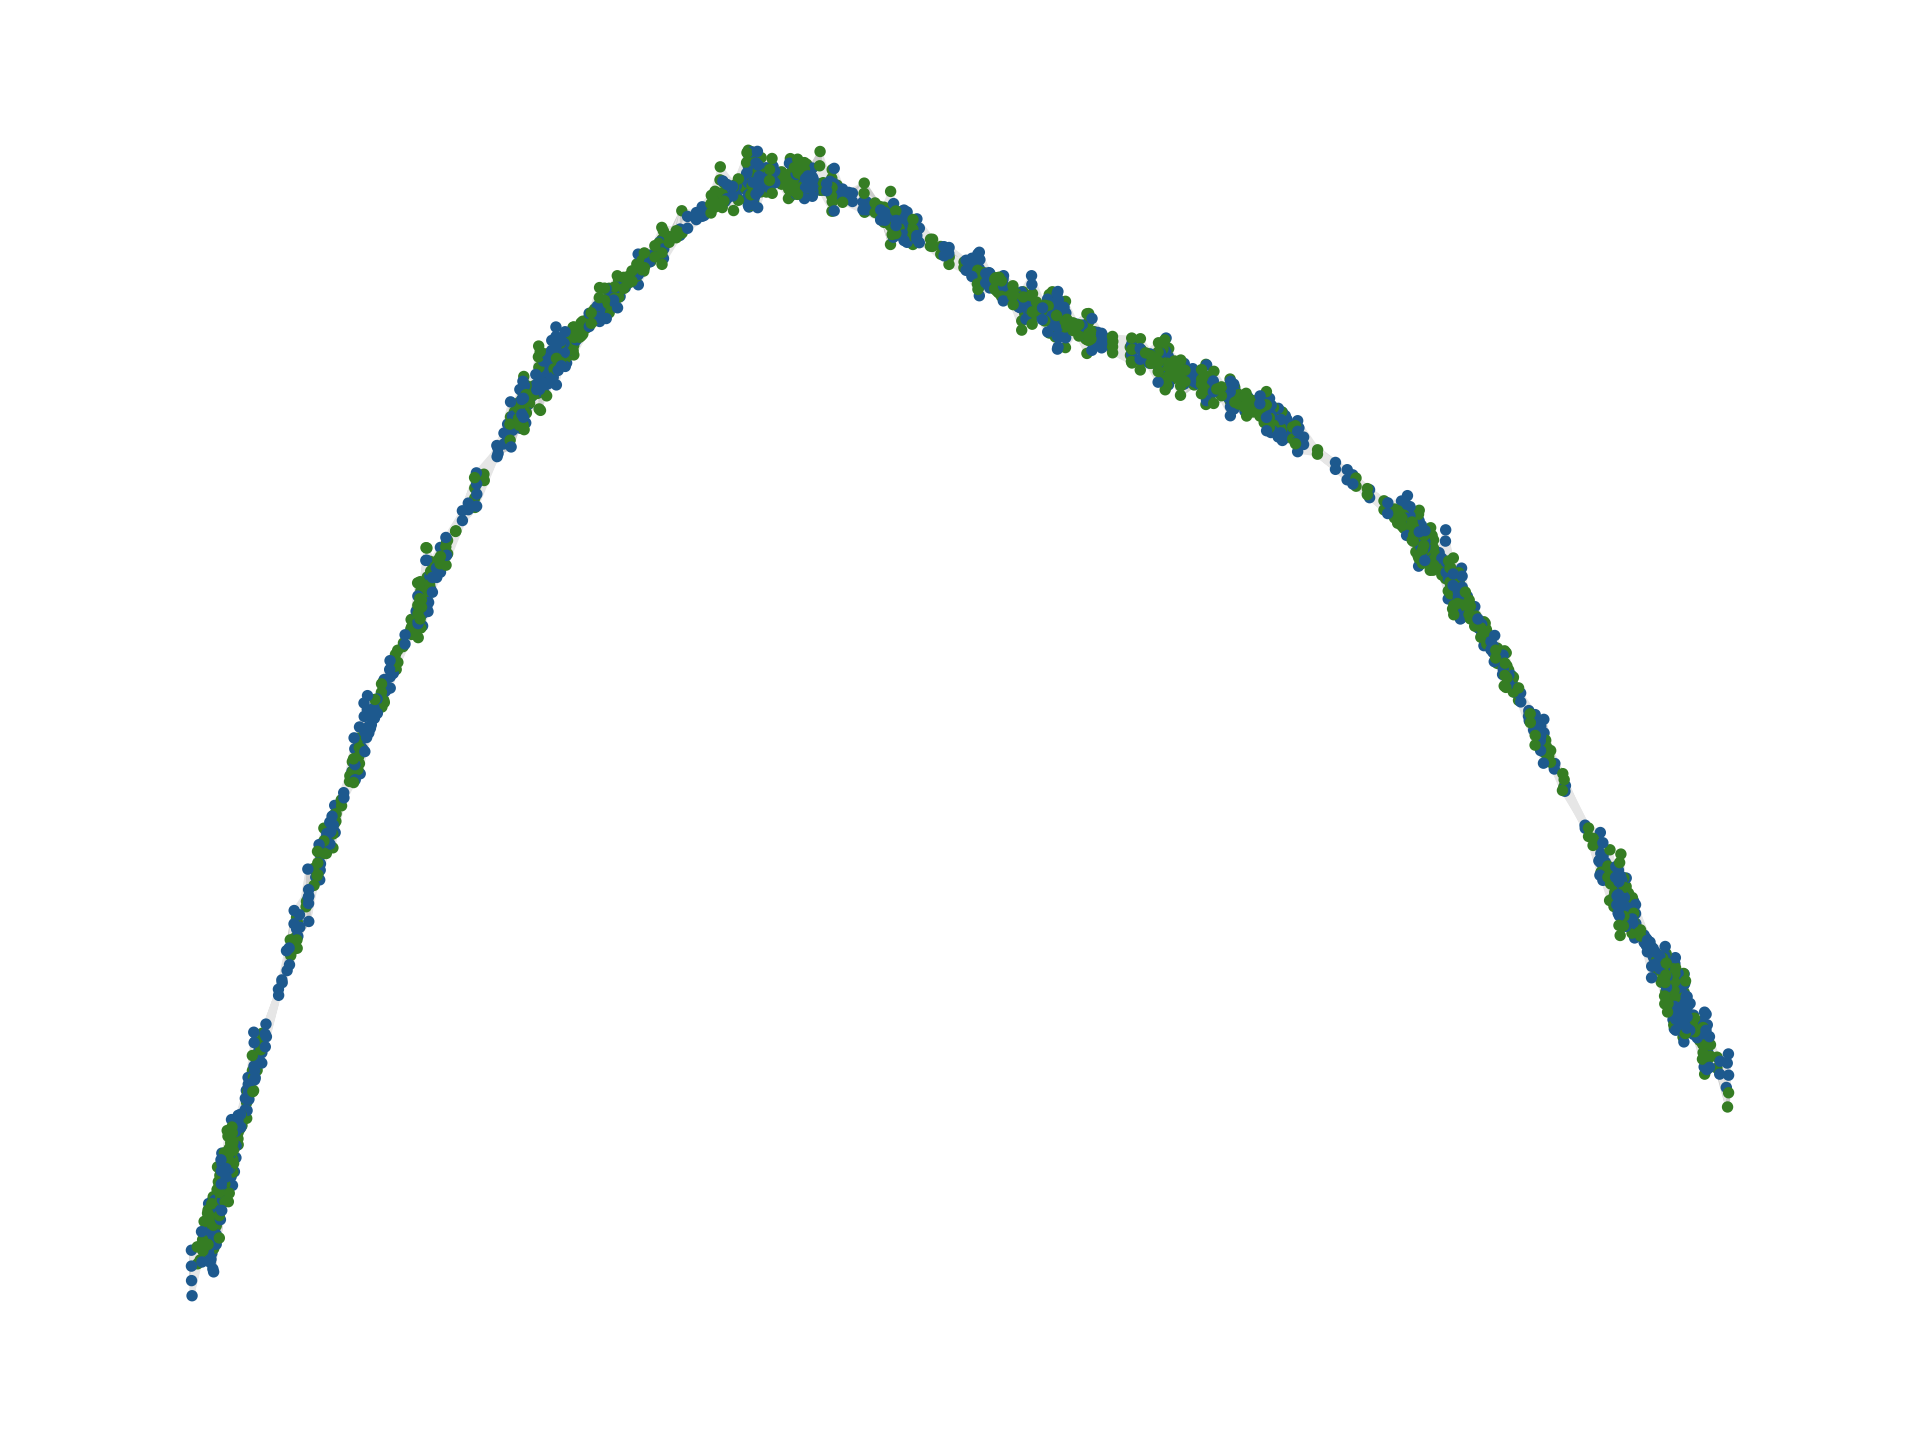

In [98]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_read_graph(ax, reference_graph=reference_graph, metadata=meta_df)

In [99]:
def plot_configs(configs, reference_graph, metadata, **kw):
    graphs = [config.graph for config in configs]
    figures, axes = mp_plot_read_graphs(graphs, reference_graph=reference_graph, metadata=metadata, **kw)
    for ax, config in zip(axes, configs):
        ax.text(0, 0, str(config), ha='left', va='bottom', transform=ax.transAxes, wrap=True)
        ax.axis('off')
    return figures, axes

5 3 7 2 0 6 1 4 CPU times: user 6.34 s, sys: 505 ms, total: 6.85 s
Wall time: 15.5 s


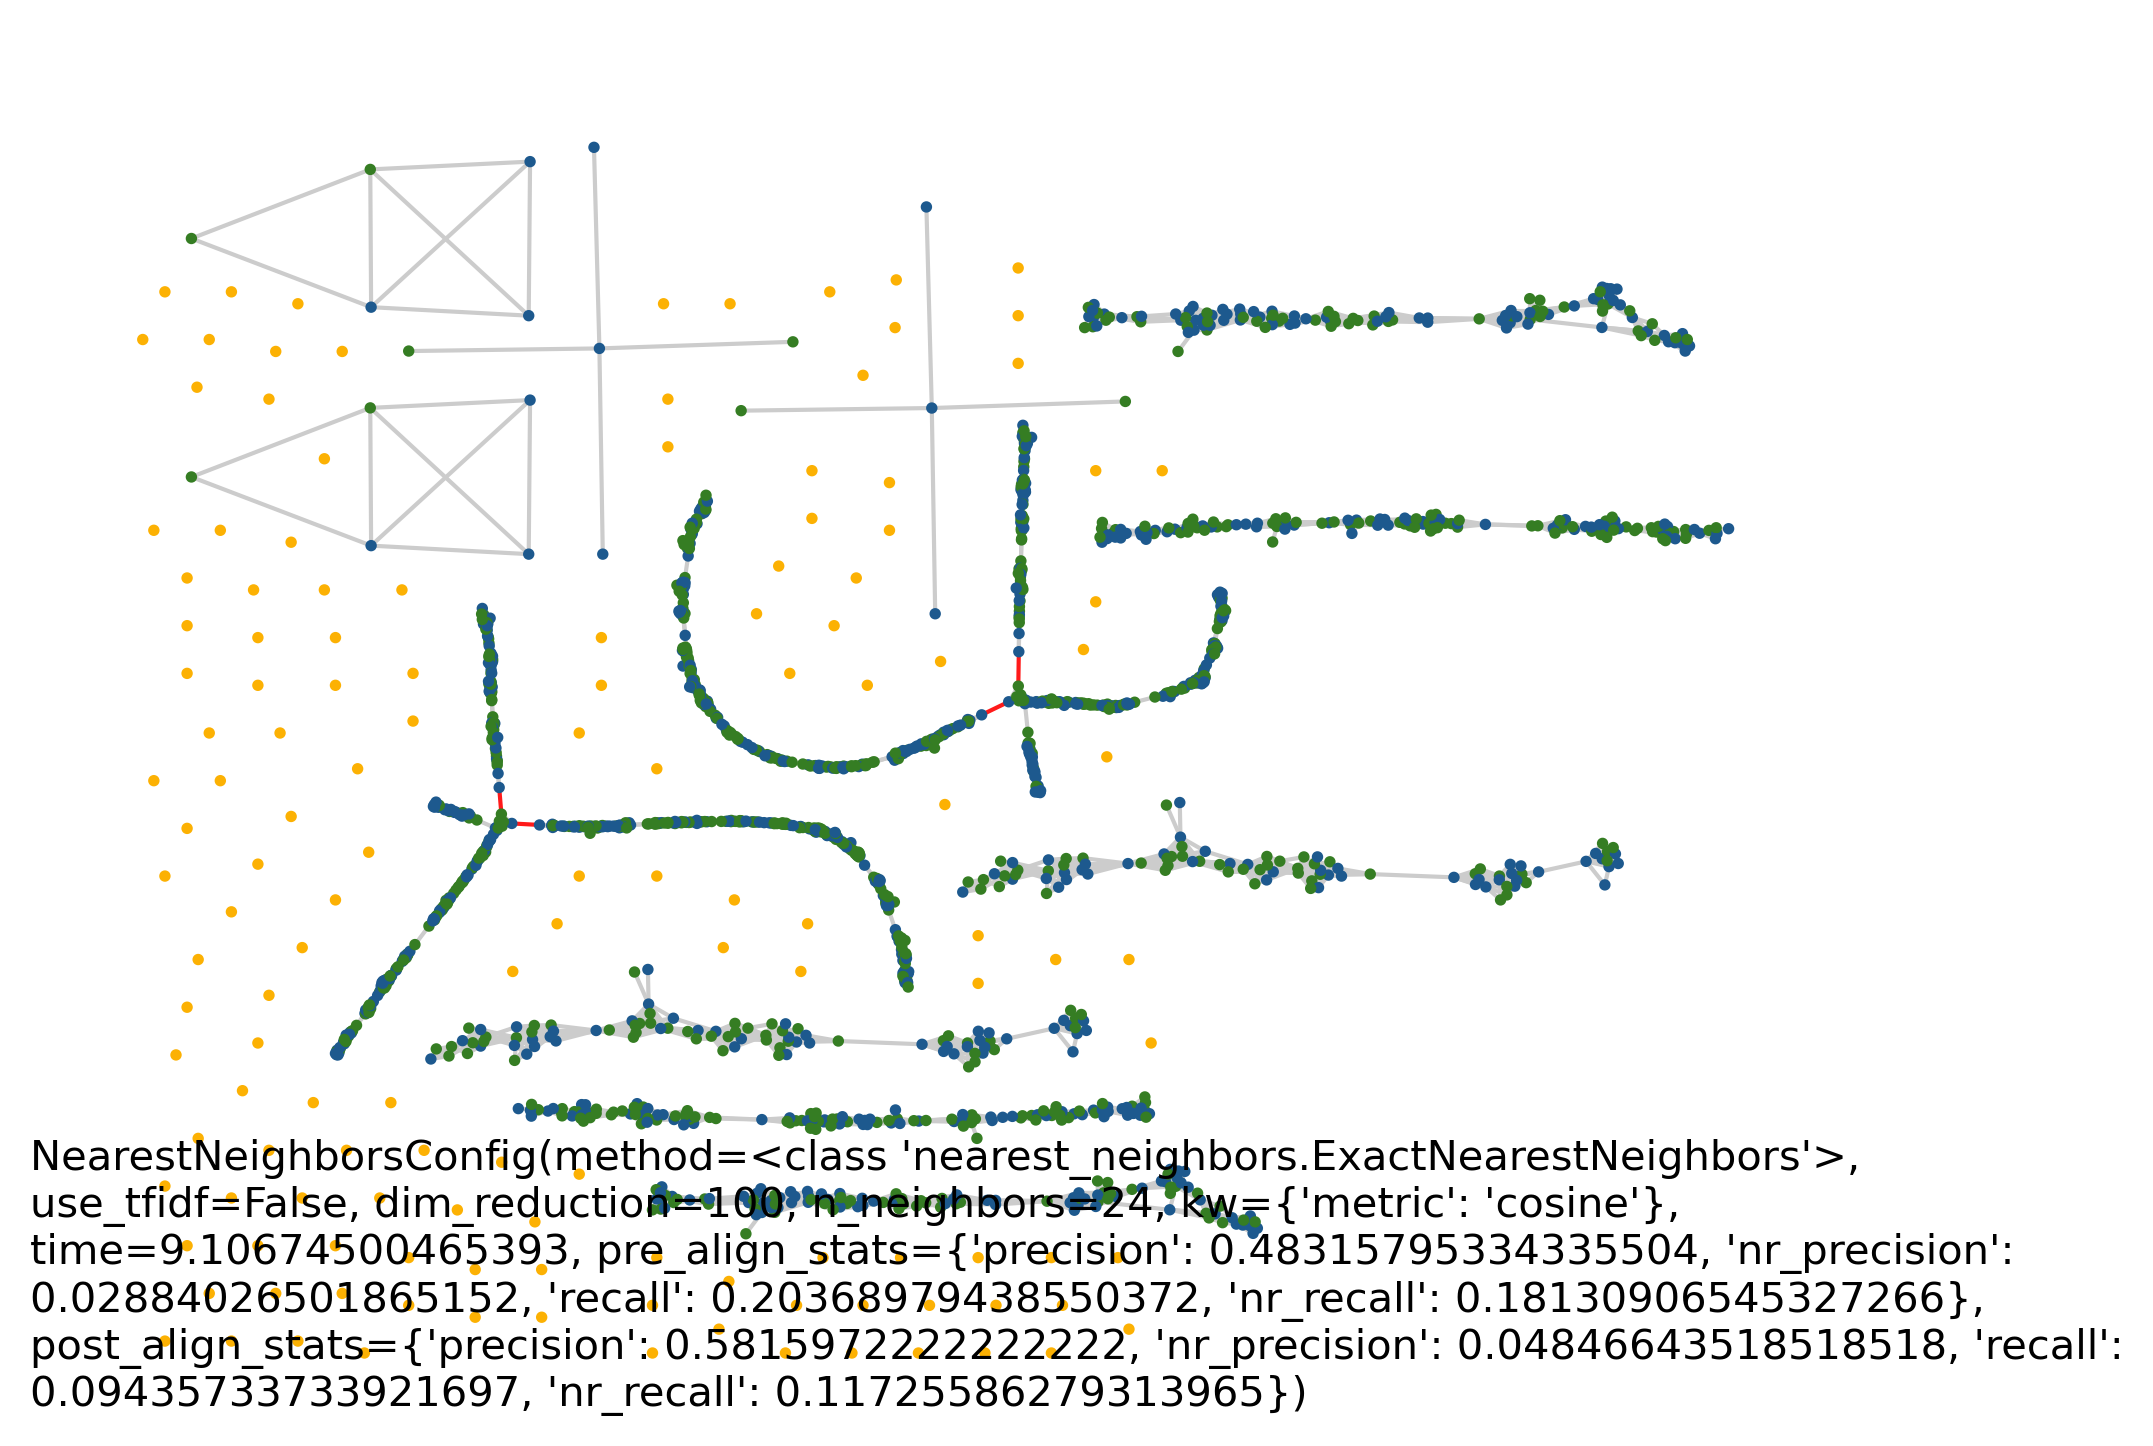

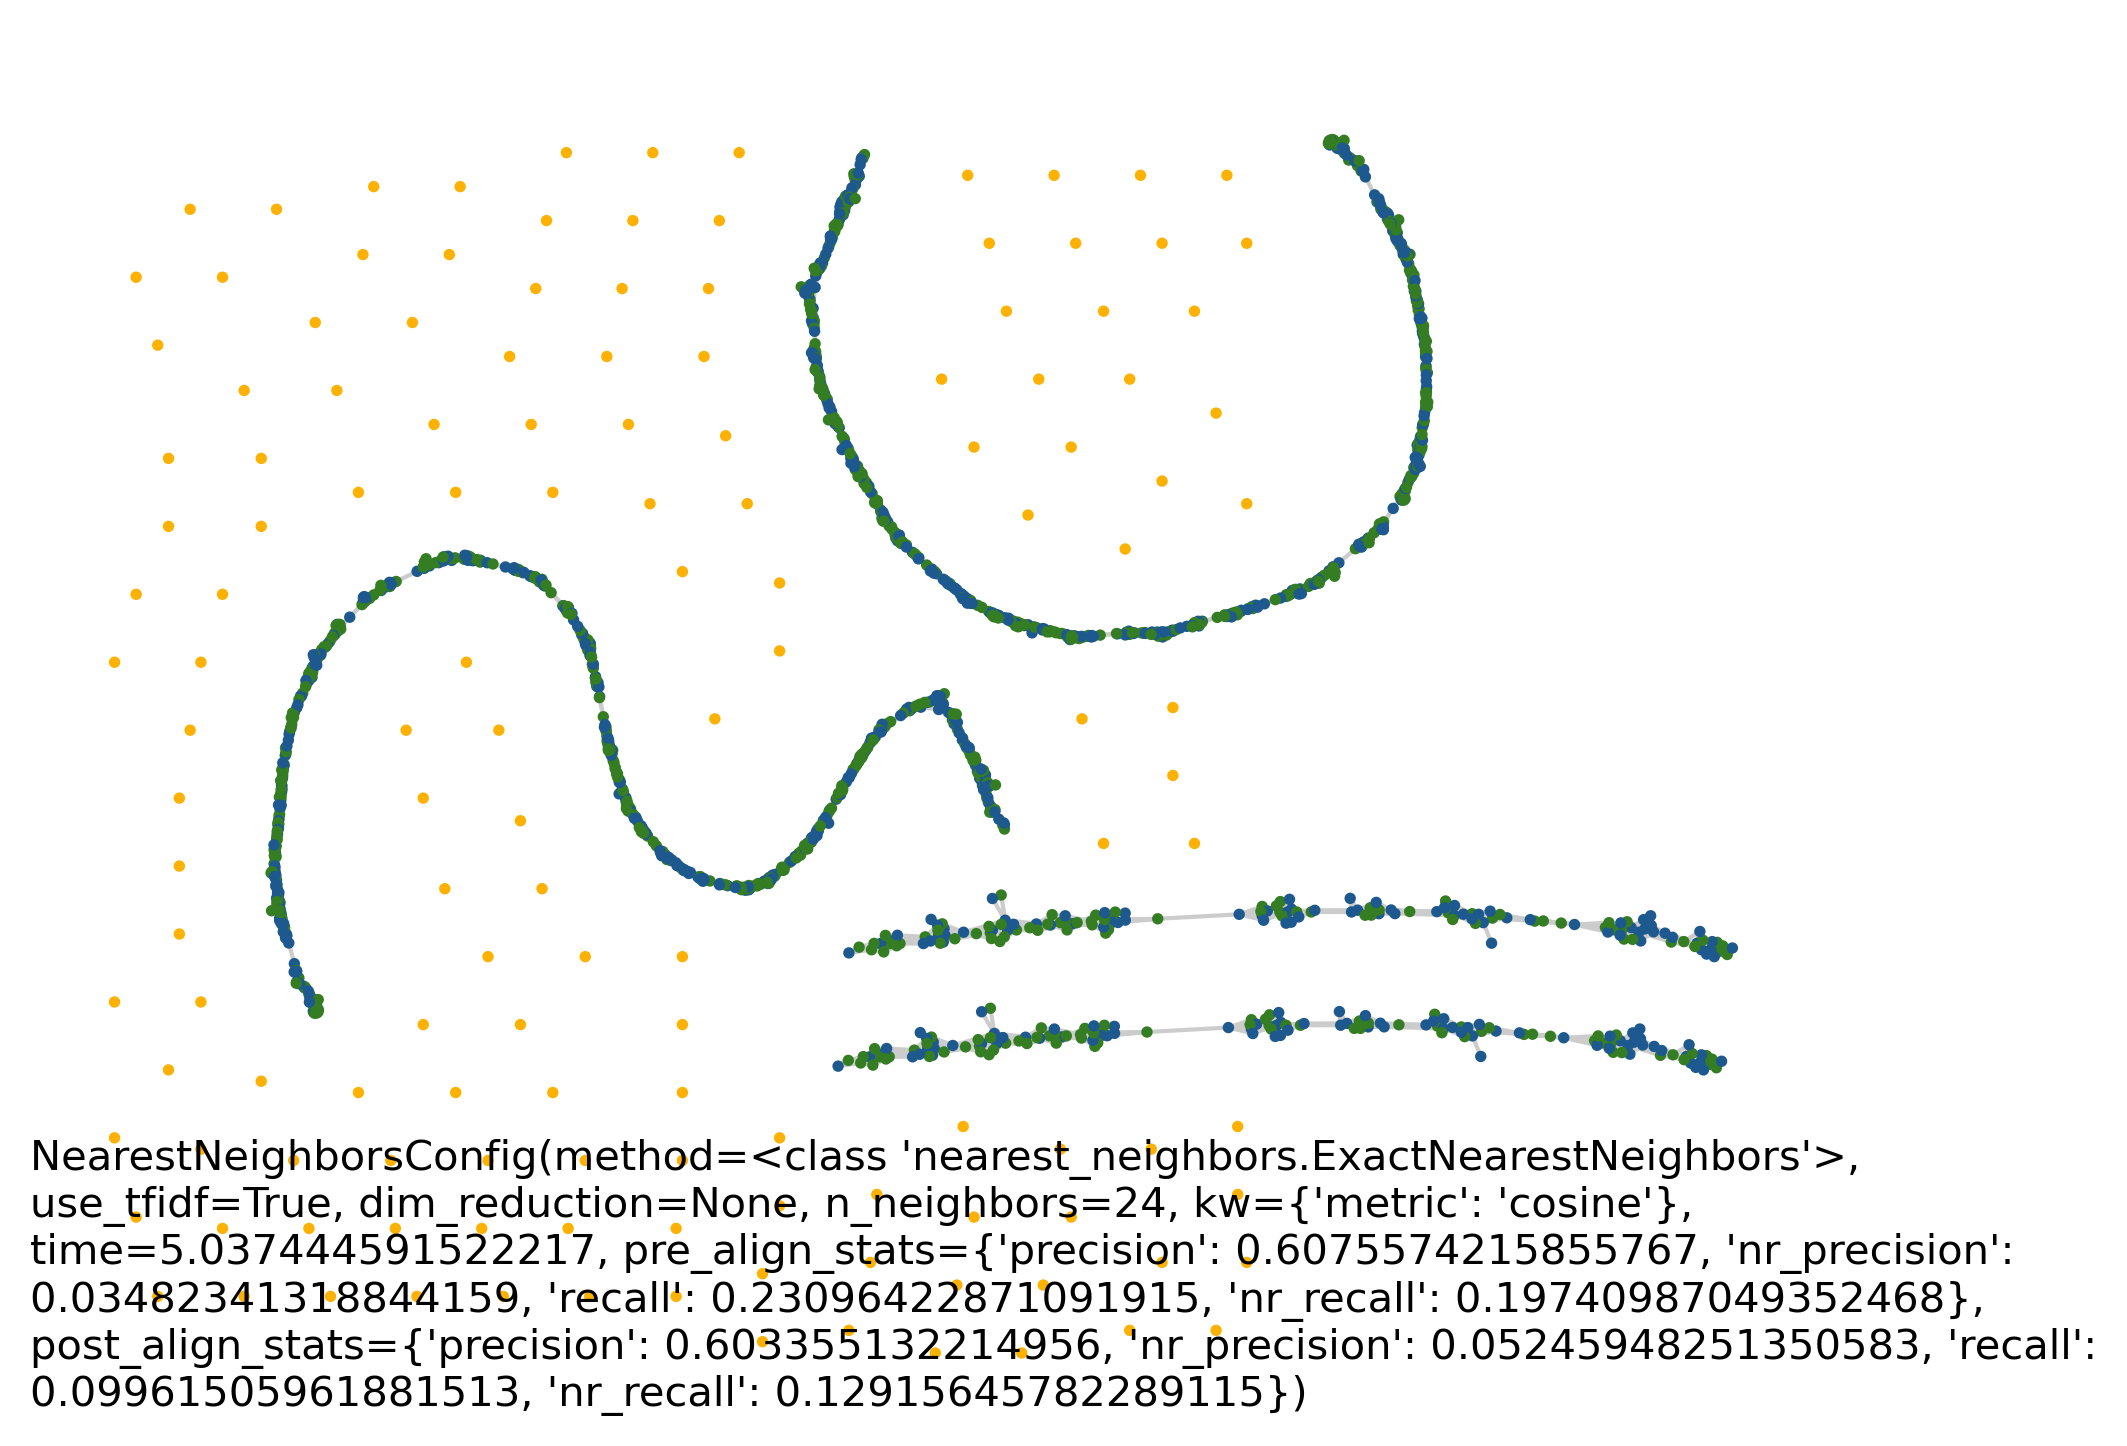

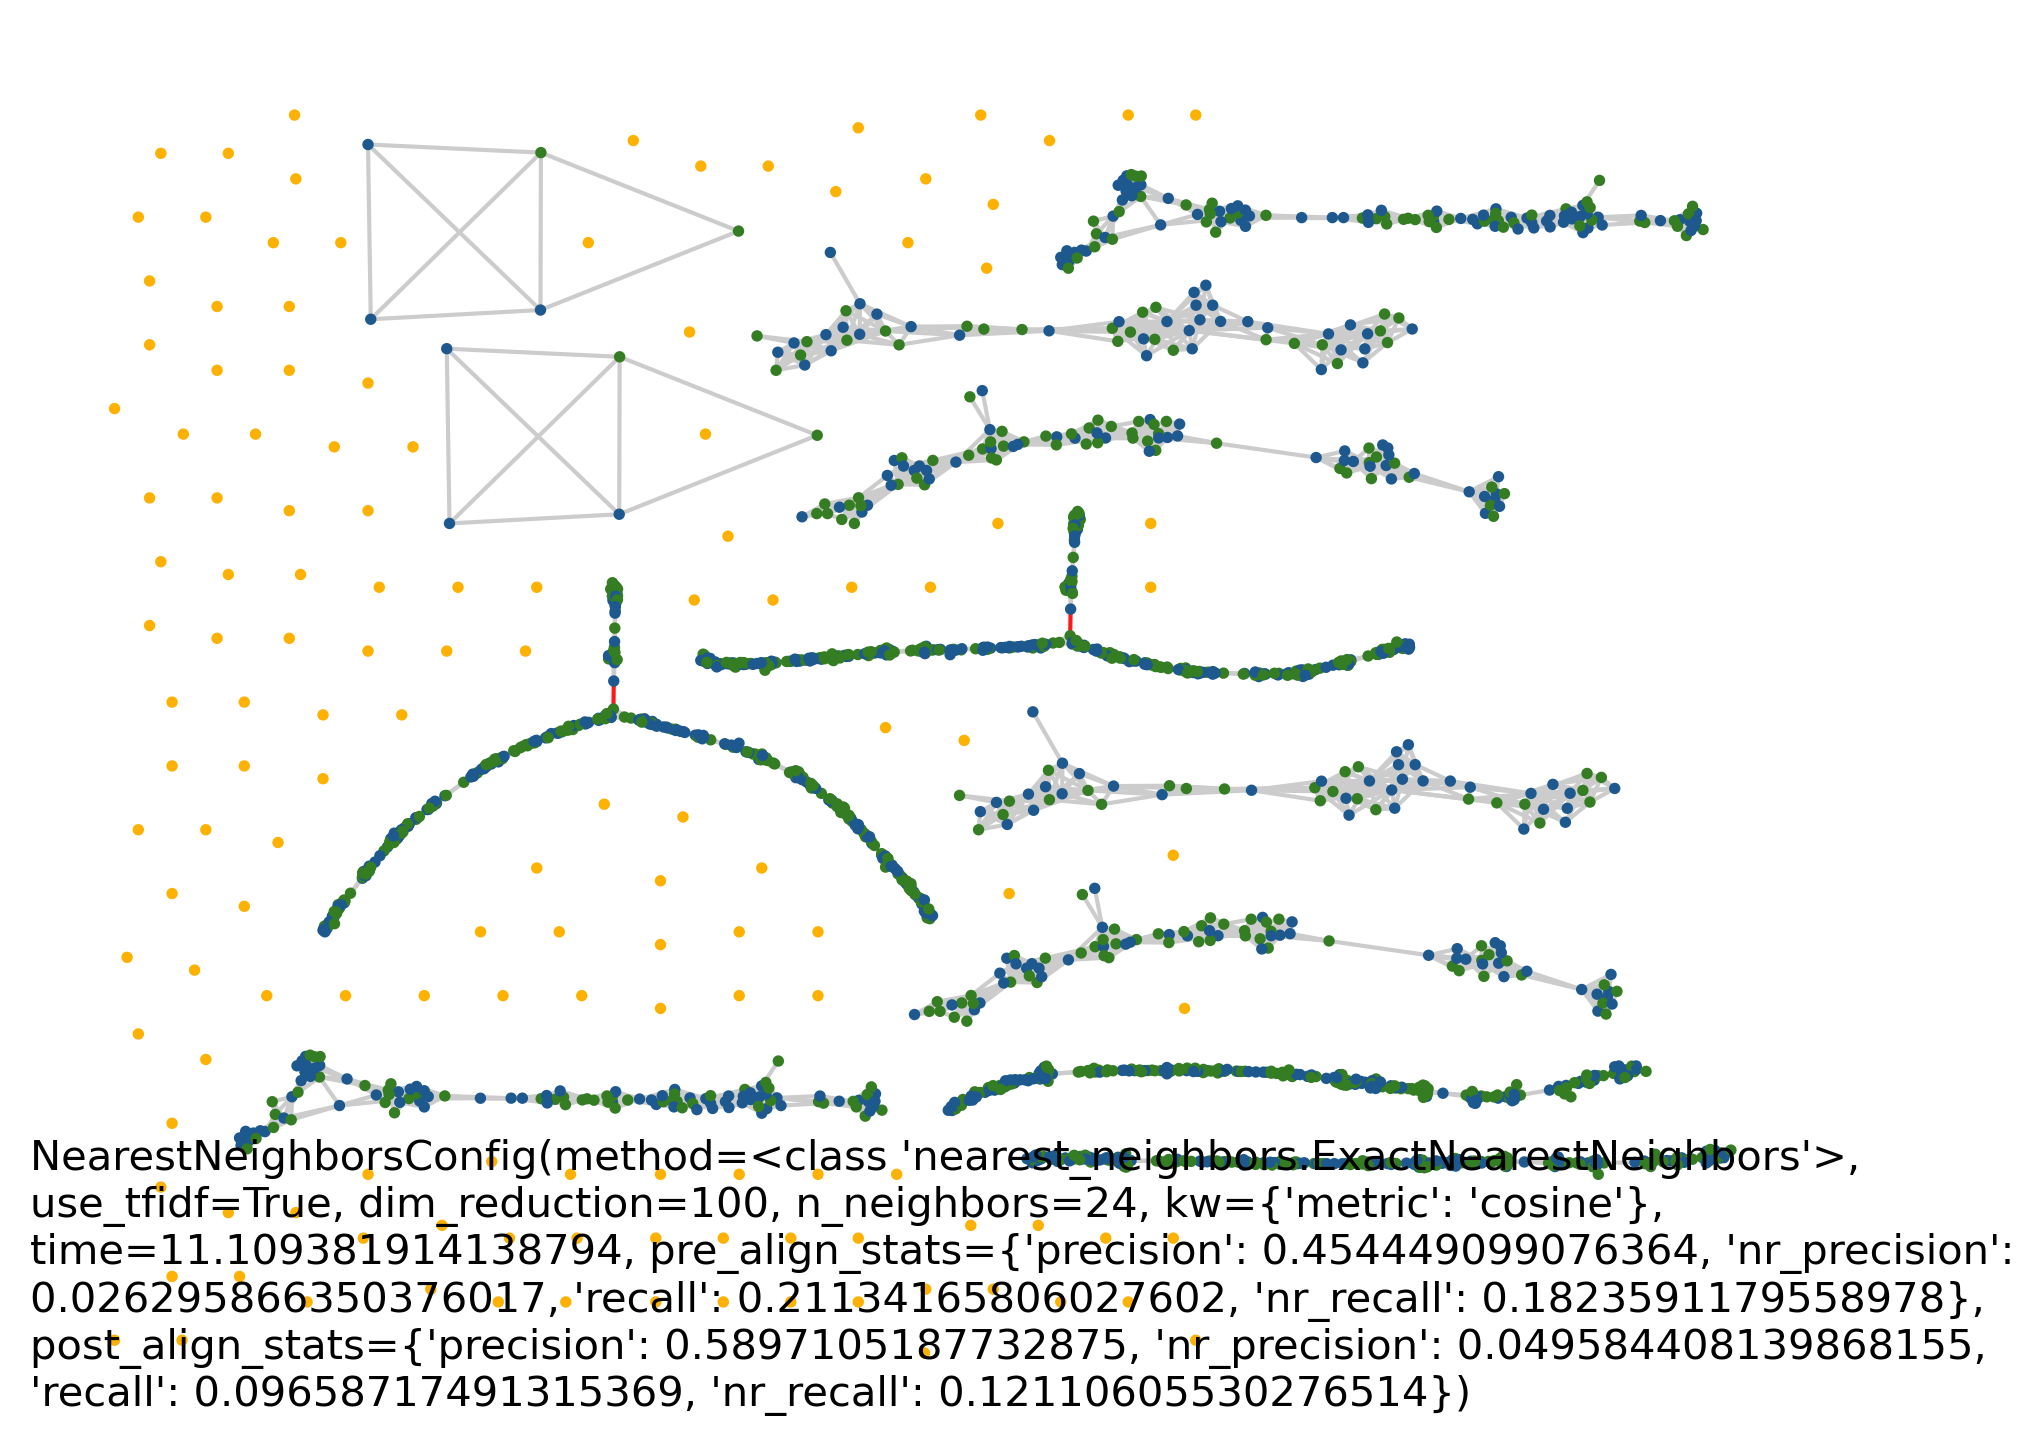

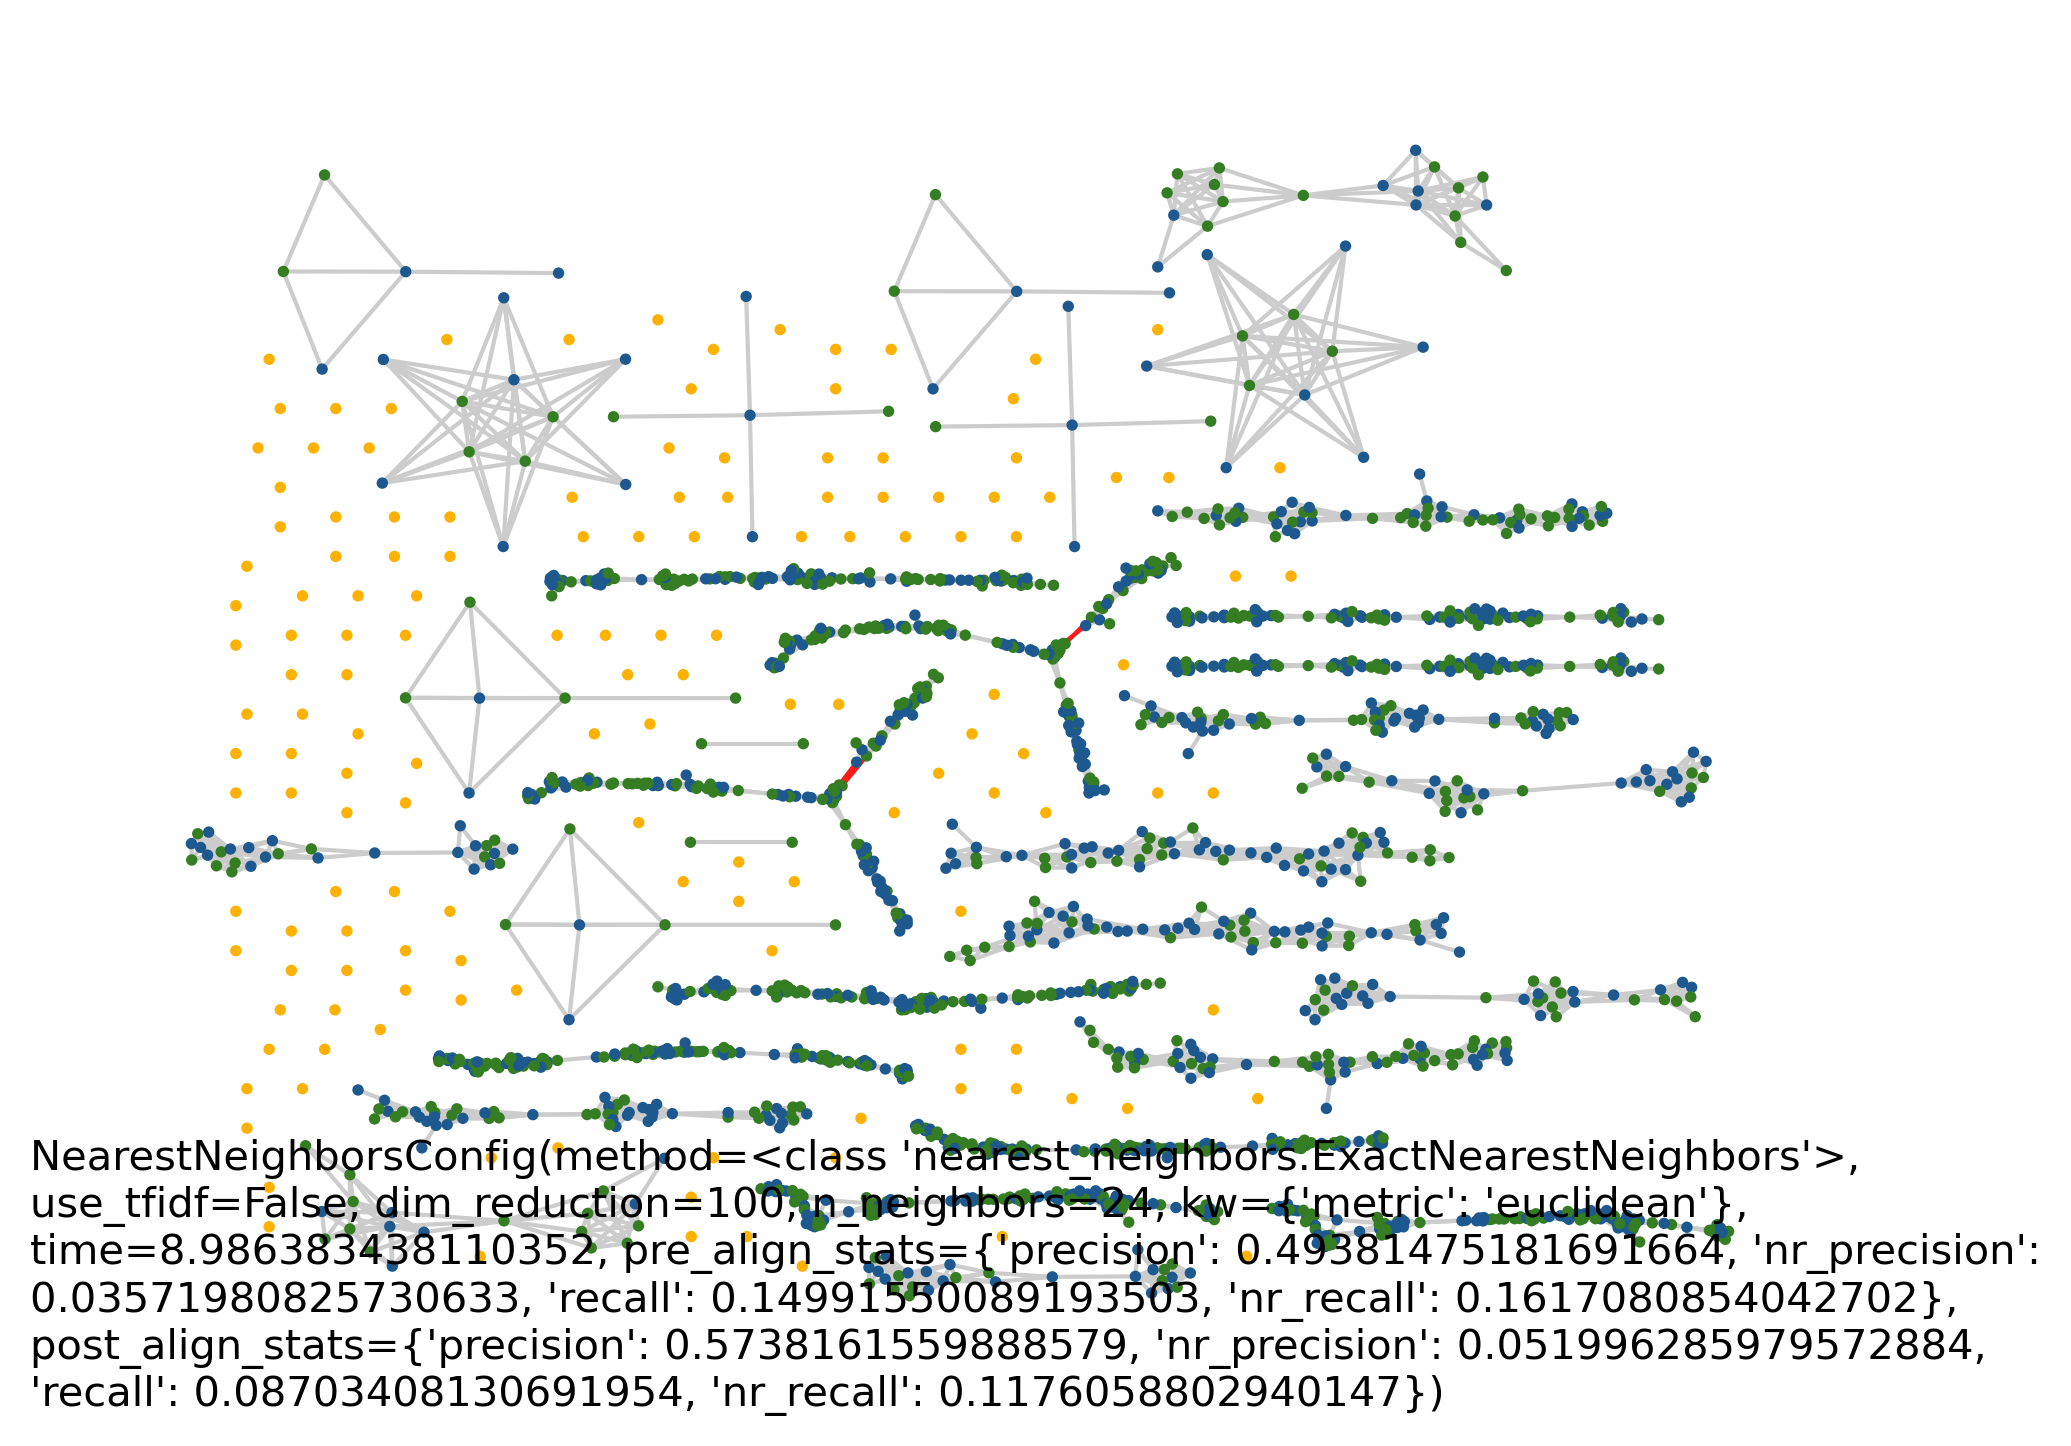

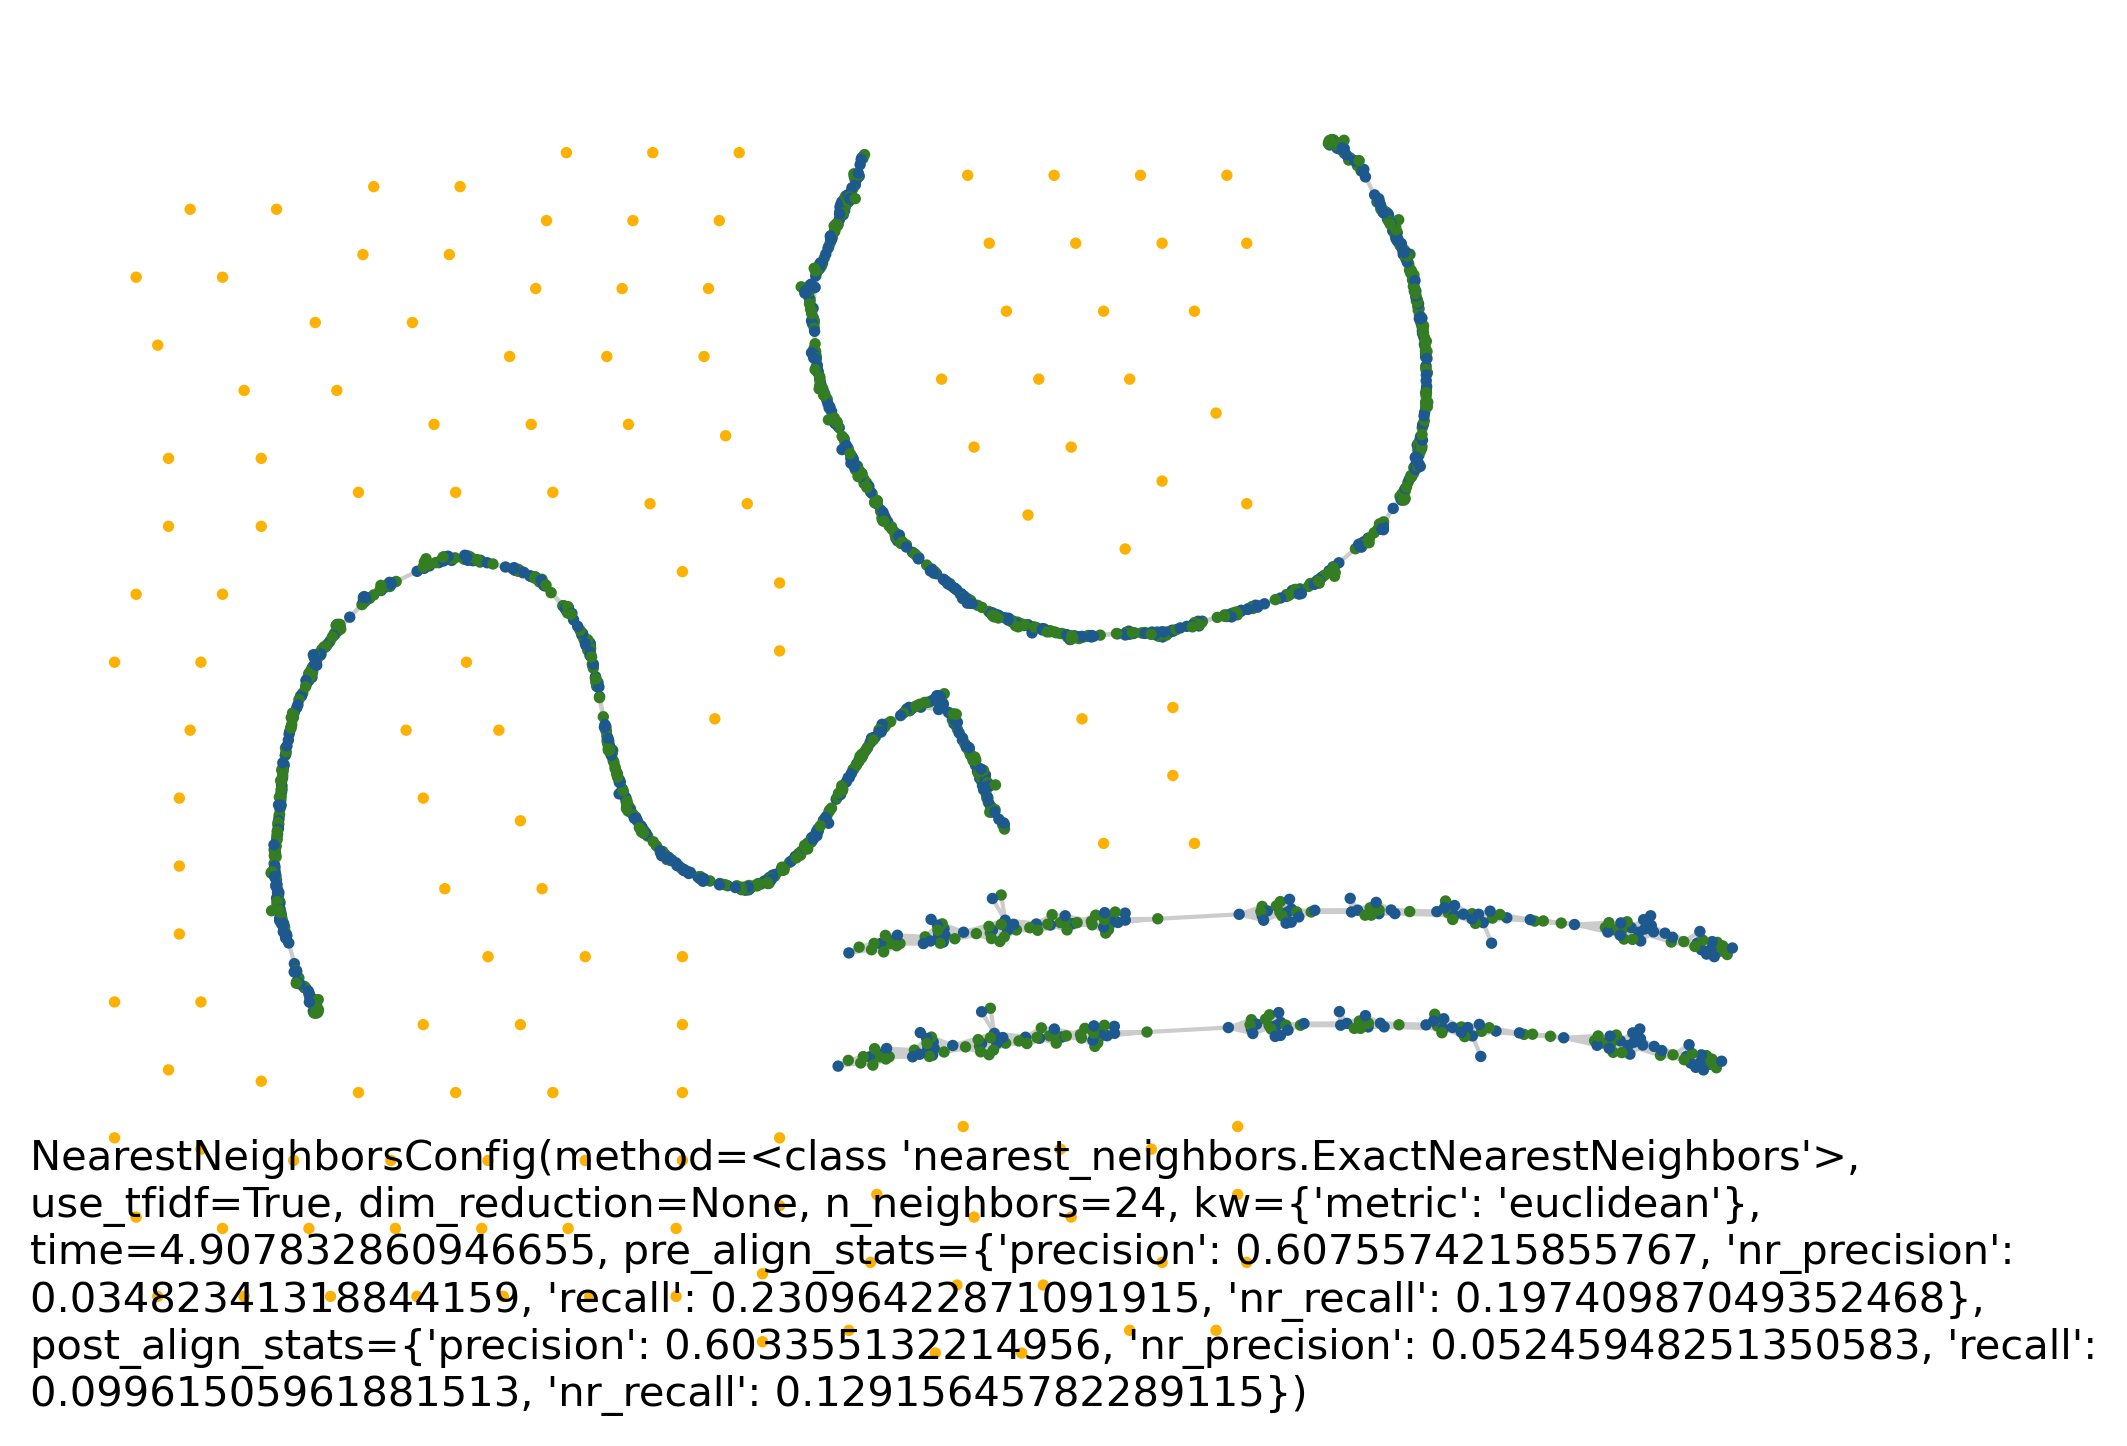

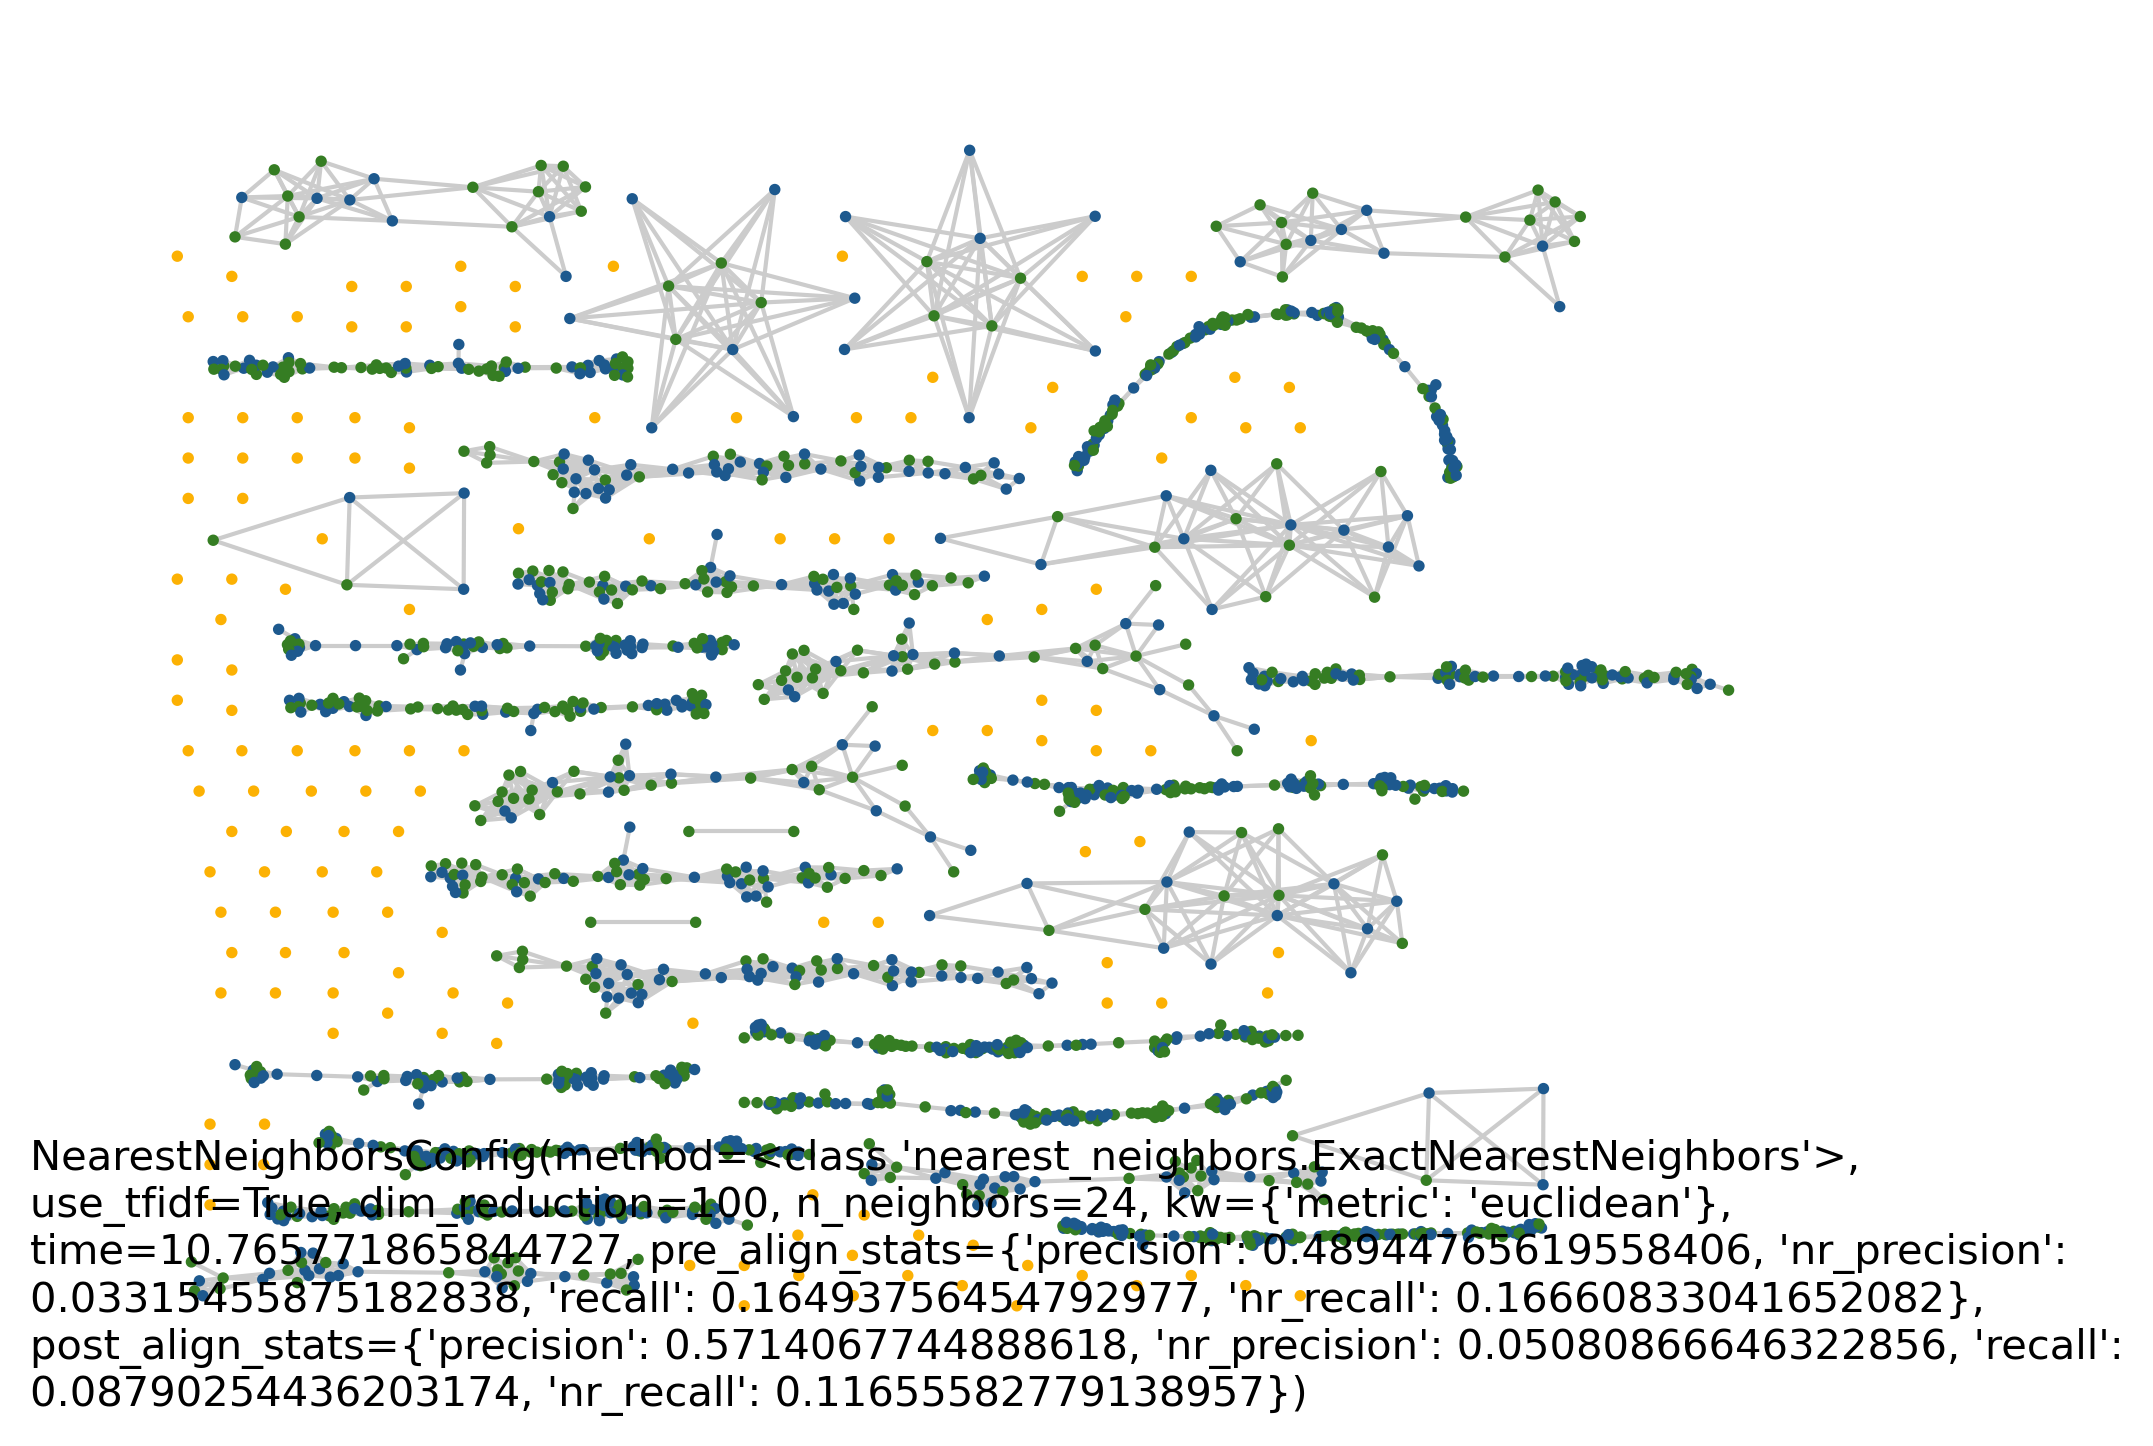

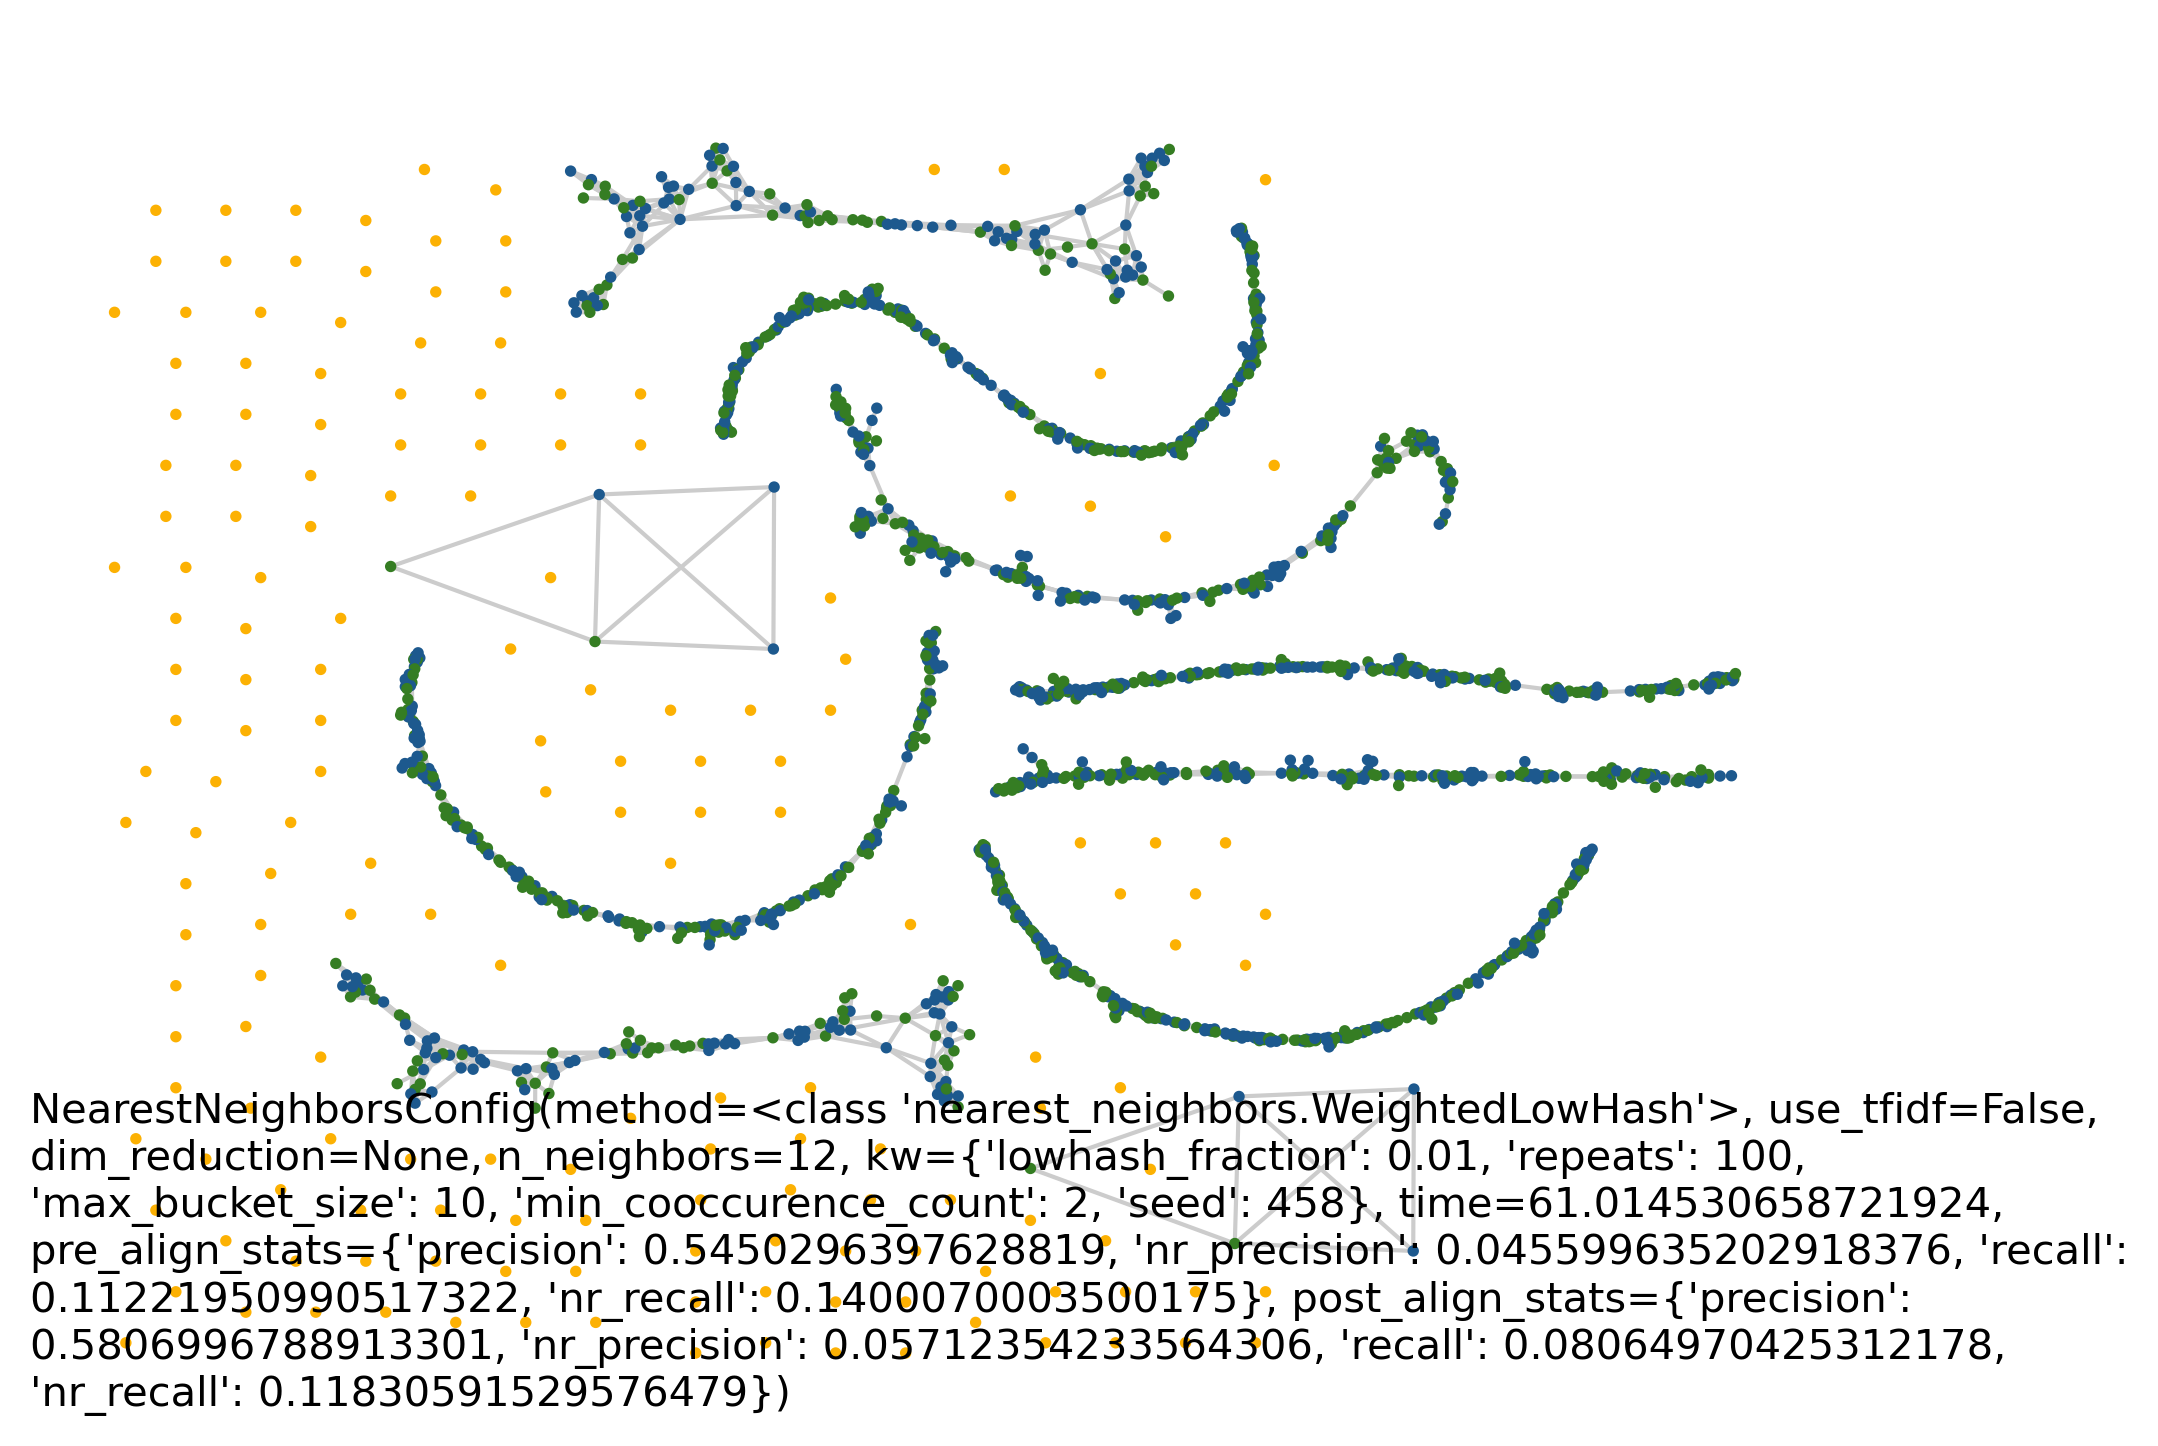

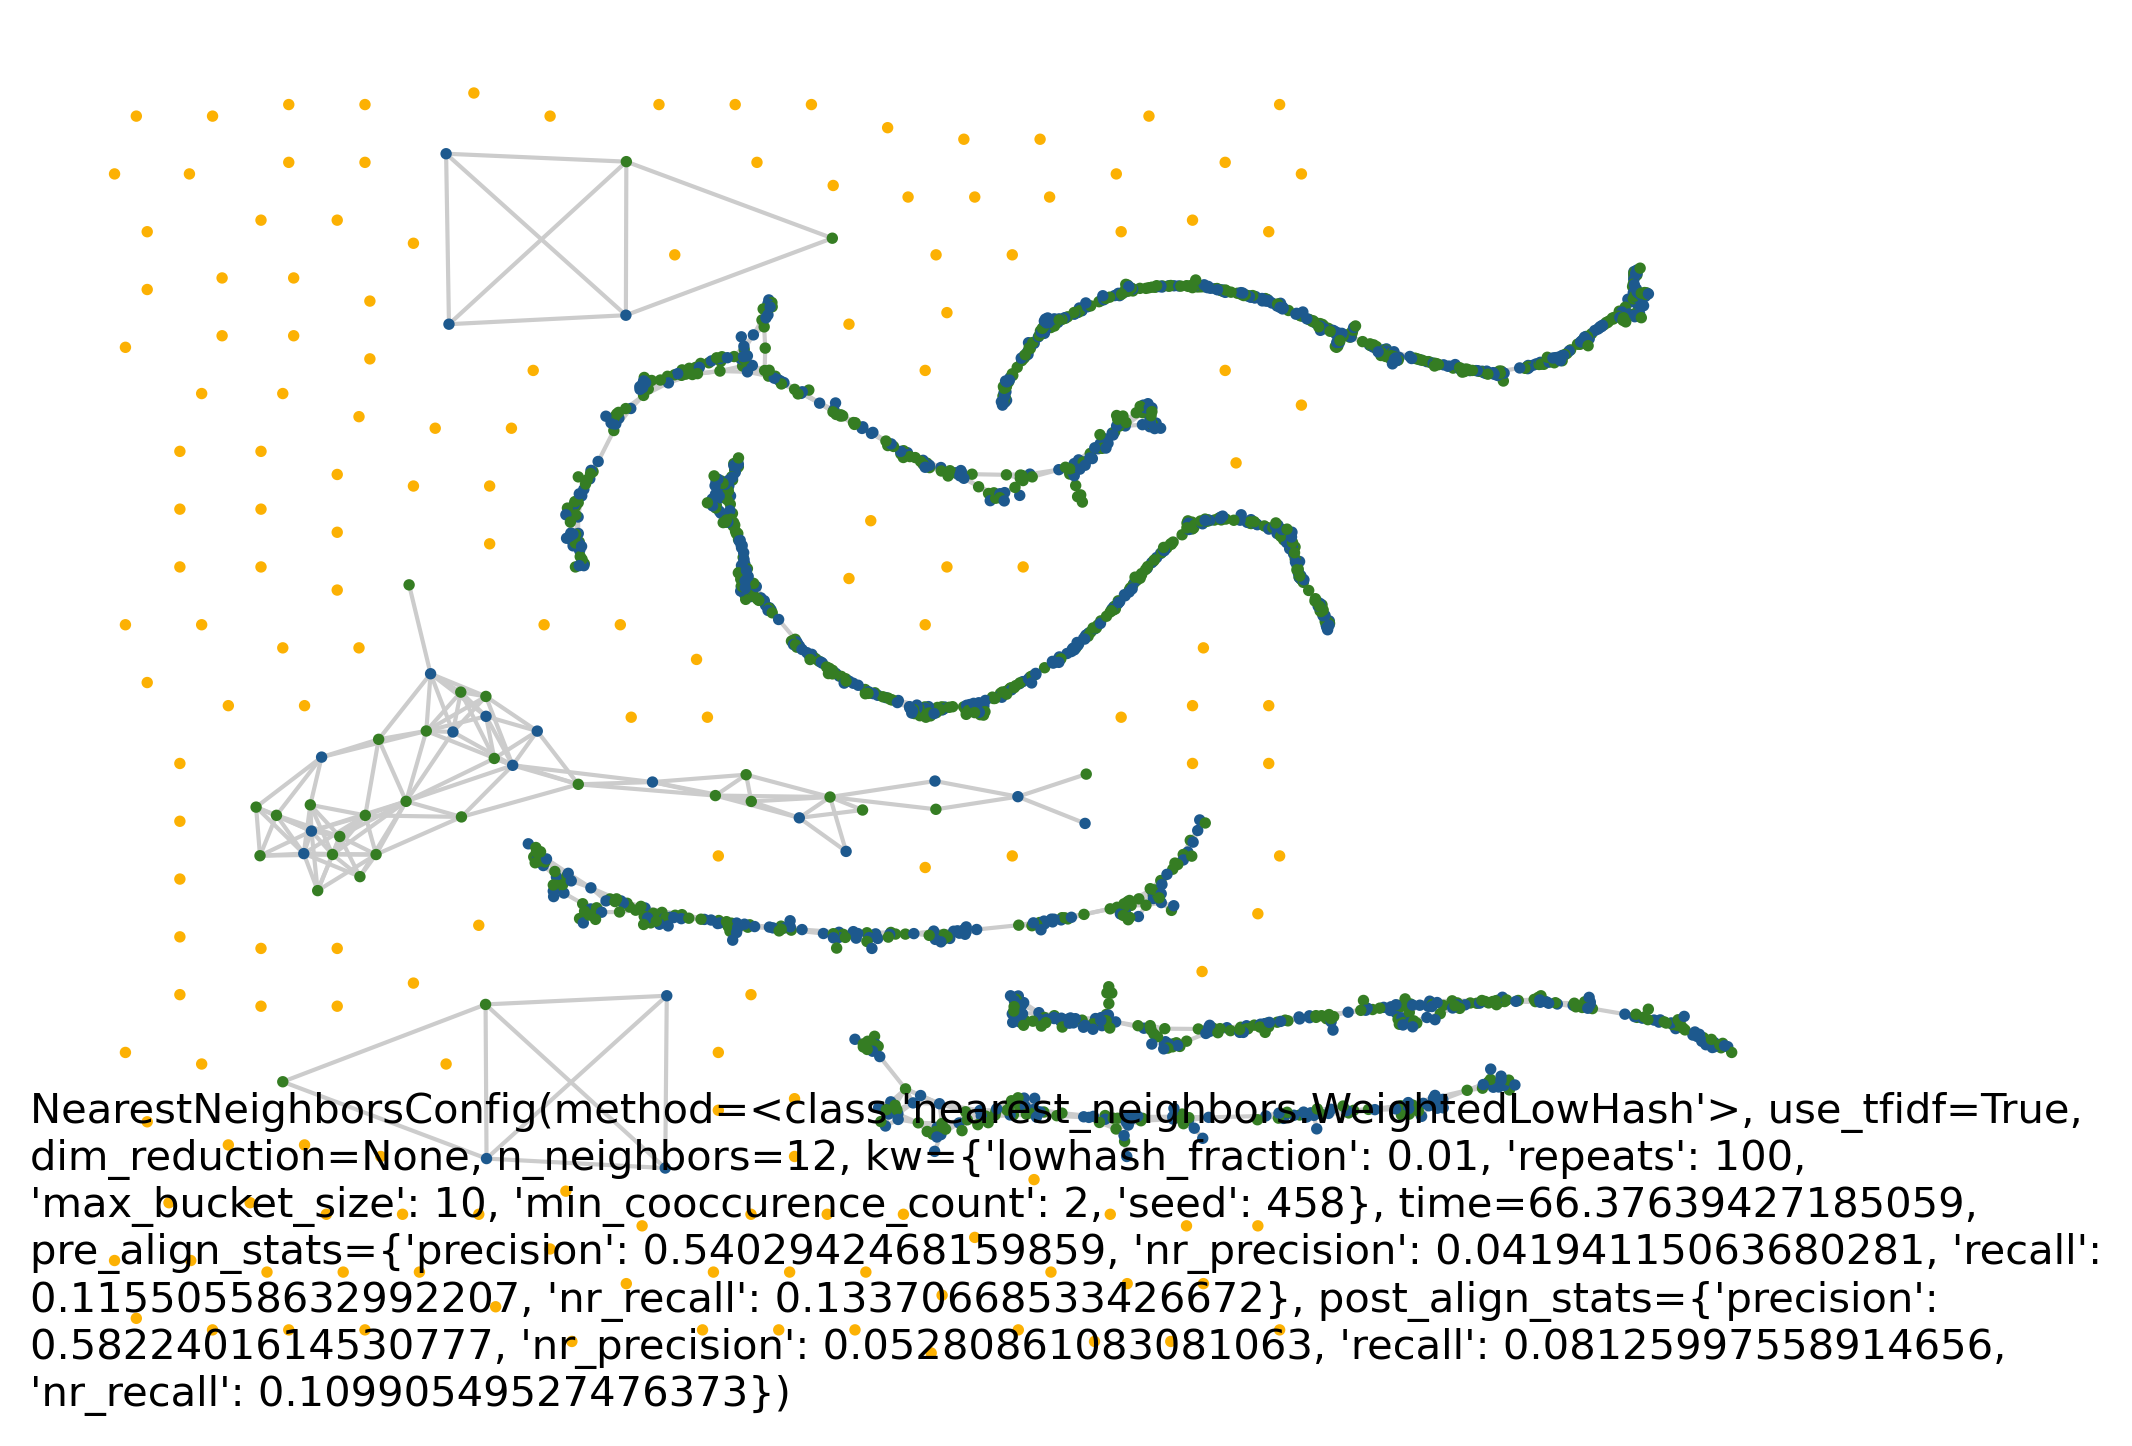

In [100]:
%%time
figures, axes = plot_configs(
    config_list, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=16
)